In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # Importing tqdm for progress bar

# Check if GPU is available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 데이터셋 전처리 설정: CIFAR-10을 사용하고 이미지 크기를 32로 리사이즈
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 학습 및 테스트 데이터셋 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Vision Transformer (ViT) 모델 구현
class MultiExitViT(nn.Module):
    def __init__(self, image_size=32, patch_size=16, num_classes=10, dim=768, depth=12, heads=12, mlp_dim=3072, dropout=0.1, emb_dropout=0.1, num_exits=3):
        super(MultiExitViT, self).__init__()

        # 패치의 크기와 이미지 크기에 맞는 패치 수 계산
        assert image_size % patch_size == 0, 'Image size must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2  # 각 패치의 차원 (RGB 이미지 기준)

        # 패치 임베딩
        self.patch_embed = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        # Transformer 블록 구성
        self.transformer = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=dim, 
                nhead=heads, 
                dim_feedforward=mlp_dim, 
                dropout=dropout
            ) for _ in range(depth)
        ])
        
        # Multiple Exit Blocks 추가
        self.num_exits = num_exits
        self.exit_blocks = nn.ModuleList([self.create_exit_block(dim, num_classes) for _ in range(num_exits)])

        # 최종 MLP Head (출력 레이어)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def create_exit_block(self, dim, num_classes):
        """Create a simple classifier block for intermediate exits."""
        return nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
    
    def forward(self, x, early_exit_threshold=None):
        # 이미지 크기 및 패치 수 설정
        batch_size = x.shape[0]
        image_size = x.shape[2]
        patch_size = 16
        num_patches = (image_size // patch_size) ** 2
        
        # 이미지를 패치로 변환: 각 패치를 일렬로 펼침
        x = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        x = x.contiguous().view(batch_size, 3, patch_size, patch_size, -1).permute(0, 4, 1, 2, 3)
        x = x.view(batch_size, num_patches, -1)

        # 패치 임베딩
        x = self.patch_embed(x)

        # 클래스 토큰 추가 및 포지셔널 임베딩 추가
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)

        # Transformer 블록 통과
        exit_outputs = []  # Early exit 결과 저장
        for i, transformer_layer in enumerate(self.transformer):
            x = transformer_layer(x)

            # Early Exit 판단
            if i < self.num_exits:
                # 현재 블록까지의 CLS 토큰을 사용하여 예측
                exit_logits = self.exit_blocks[i](x[:, 0])
                exit_outputs.append(exit_logits)

                # Early exit 조건 충족 시
                if early_exit_threshold is not None:
                    confidence = F.softmax(exit_logits, dim=-1).max(dim=-1)[0]
                    if confidence > early_exit_threshold:
                        return exit_logits, i + 1  # 예측 값과 종료된 블록 번호 반환

        # 마지막 블록 후 MLP Head로 최종 출력
        final_output = self.mlp_head(x[:, 0])
        return final_output, len(self.transformer)

# 모델 인스턴스 생성
model = MultiExitViT(num_classes=10).to(device)  # Move model to the device

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 함수 정의 (tqdm 적용)
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # 모델을 학습 모드로 전환
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loader = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")  # tqdm으로 Progress Bar 설정
        for inputs, labels in epoch_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device
            optimizer.zero_grad()  # 그래디언트 초기화
            outputs, _ = model(inputs)  # 모델 예측 (최종 출력을 사용)
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파 수행
            optimizer.step()  # 가중치 업데이트
            running_loss += loss.item()
            epoch_loader.set_postfix(loss=running_loss / len(train_loader))  # Loss 표시

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


# 모델 학습
train_model(model, train_loader, criterion, optimizer, num_epochs=2)

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


Epoch [1/2]: 100%|██████████| 782/782 [03:25<00:00,  3.81it/s, loss=2.37] 


Epoch [1/2], Loss: 2.3671


Epoch [2/2]: 100%|██████████| 782/782 [03:24<00:00,  3.82it/s, loss=2.31] 

Epoch [2/2], Loss: 2.3137


In [ ]:
# 평가 함수 정의
def evaluate_model(model, test_loader, early_exit_threshold=None):
    model.eval()  # 모델을 평가 모드로 전환
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device
            outputs, exit_layer = model(inputs, early_exit_threshold)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Exited at layer {exit_layer}')
    print(f'Accuracy: {100 * correct / total:.2f}%')
# 모델 평가 (early exit threshold 설정)
evaluate_model(model, test_loader)  # 90% 신뢰도 기준으로 조기 종료

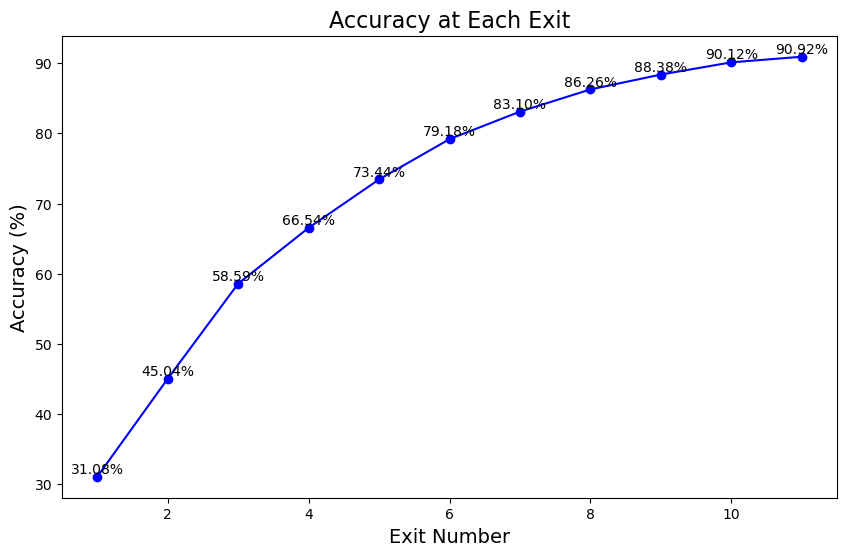

In [3]:
import matplotlib.pyplot as plt

exits = list(range(1, 12))

accuracy = [31.08, 45.04, 58.59, 66.54, 73.44, 79.18, 83.10, 86.26, 88.38, 90.12, 90.92]

plt.figure(figsize=(10, 6))
plt.plot(exits, accuracy, marker='o', linestyle='-', color='b')

plt.title('Accuracy at Each Exit', fontsize=16)
plt.xlabel('Exit Number', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)

for i, acc in enumerate(accuracy):
    plt.text(exits[i], acc + 0.5, f'{acc:.2f}%', ha='center')

plt.show()